## Adquisición de imágenes Sentinel vía Google Earth Engine

Para poder aprovechar este código es necesario contar con una cuenta de usuario en Google Earth Engine. 

De no contar aún con una cuenta, puede realizarle el registro con los siguientes pasos:

1. Ingresar en  https://signup.earthengine.google.com/, utilizando un correo electrónico de Google.
2. Completar los datos solicitados. 
3. Revisar los términos, y cliquear en "Submit".
4. Esperar a que aparezca en nuestra casilla de correo un mensaje del equipo de desarrolladores de Google, con un enlace para realizar la confirmación del alta.

Una vez recibido el acceso, podemos continuar.

In [ ]:
import ee
import geemap
import os

### Inicializar (y autorizar) la conexión con Google Earth Engine

Al invocar función `Map()` de _geemap_ realizamos una conexión a los servidores de Google Earth Engine. Si es la primera vez que lo hacemos, deberemos completar antes un proceso de autorización, estableciendo con la conexión se realiza bajo nuestra cuenta de usuario.

En ese caso, se nos ofrecerá un link a seguir para autorizar la conexión, obteniendo un código de acceso, y debajo una caja de texto donde ingresar el código obtenido:

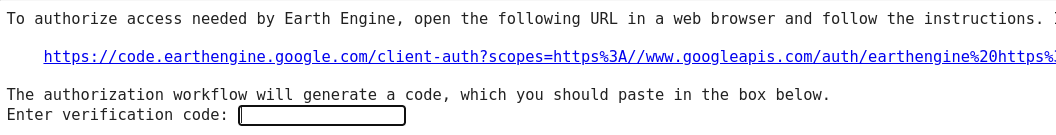

Seguir el enlace, cliquear en "Generate token".

En la pantalla que nos advierte que sólo debemos continuar si conocemos el origen de la solicitud, elegir "Continue". 

Luego otorgar los permisos requeridos ("View and manage"... "Manage your data..."), y cliquear en "Continue".

Así obtendremos un "Authorization code", que es el que hay que copiar y pegar en la ventana en la celda del notebook.

In [ ]:
# Con esto inicializamos GEE
Map = geemap.Map()

In [ ]:
# Definimos funciones auxiliares

def maskS2clouds(img):
    qa = img.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return img.updateMask(mask).divide(10000)

def buildS2Composite(collection, date_start, date_end, poli):

    # La banda QA60 contiene informacion sobre presencia de nubes
    images = collection.select(['B4', 'B3', 'B2','B8','B11','B12','QA60']) \
        .filterBounds(poli) \
        .filterDate(date_start, date_end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', PORCENTAJE_NUBES))

    n_images = images.size().getInfo()
    print(str(n_images) + " imágenes con menos de " + str(PORCENTAJE_NUBES) + "% de nubes disponibles entre " + date_start + " y " + date_end)
    
    return images \
        .map(maskS2clouds) \
        .select(['B4', 'B3', 'B2','B8','B11','B12']) \
        .reduce(ee.Reducer.median()) \
        .clip(poli)


In [ ]:
# Proyección a utilizar para las imágenes generadas
target_crs = 'EPSG:4326'

# Resolución en metros por pixel, para las imágenes generadas
# Sentinel 2 alcanza una resolución de 10 m/pixel
target_res = 10

In [ ]:
# Área de interés
AoI = ee.Geometry.Polygon(
        [[[-59.22695, -35.22655],
          [-59.22695, -34.00694],
          [-57.81048, -34.00694],
          [-57.81048, -35.22655],
          [-59.22695, -35.22655]]])


# nombre del area, se utilizará como sufijo para el nombre de las imagenes descargadas
desc_AoI = 'RMBA'

In [ ]:
#### Alternativas para definir "Area of Interest": 

## Tomada de un polígono en un archivo shapefile 
## (El archivo debe tener formato .shp, acompañado en su directorio por los archivos complementarios .prj .dbf, etc)
AoI_shp = '../data/aoi/RMBA/RMBA_envolvente.shp'
AoI = geemap.shp_to_ee(AoI_shp).geometry()


### Dibujada a mano alzada sobre el mapa 
#Map  # (dibujar a mano tras cliquear el ícono del pentágono, "Draw a polygon")
#feature = Map.draw_last_feature

In [ ]:
# podemos ver el área de interés definida en el mapa:

Map.addLayer(AoI)
Map

nota: a mediados de 2023 en Sagemaker Lab no funciona la generación de mapas interactivos, pero cuando arreglen eso, o al correr este código en otro sistema, debería verse el área de interés en un mapa navegable, asi:

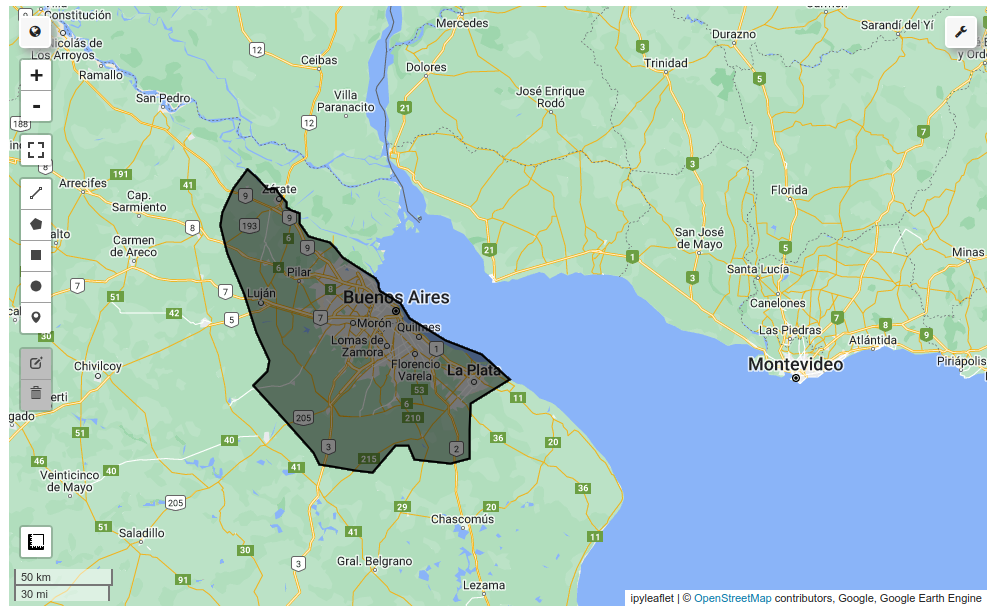

In [ ]:
# Rango de fechas (inicio, fin) para el cual obtener imágenes a combinar en un compuesto "des-nubificado"
# ATENCIÓN: Deben ser fechas válidas (o sea, no indicar el día 31 de un mes que no pasa de 30)
DATES = [
  ['2020-01-01', '2020-01-31'],
  ['2019-08-01', '2019-08-31']
  ]

In [ ]:
# Fuente de imágenes a utilizar
s2 = ee.ImageCollection("COPERNICUS/S2")

# Máximo porcentaje de área cubierta por nubes que podemos aceptar
PORCENTAJE_NUBES = 1

### Descargar imágenes

In [ ]:
# Nombre de carpeta en Google Drive donde dejar las imágenes (puede incluir subdirectorios, como "GGE/RMBA/Sentinel")
gdrive_folder = "GEE"

In [ ]:
# Recorremos cada pareja de fechas inicio/fin definidas antes, y para cada una
# generamos una imagen compuesta sin nubes e iniciamos una operación
# en GEE para transferir el resultado a nuestro Drive

for i in range(0, len(DATES), 1):

    date_start = DATES[i][0]
    date_end = DATES[i][1]

    # Generar una imagen compuesta sin nubes.
    scene = buildS2Composite(s2, date_start, date_end, AoI)

    # descripción de la imagen
    desc = desc_AoI + "_" + date_start + "_" + date_end

    #Export.image.toCloudStorage({
    #      image: scene,
    #      description: desc,
    #      bucket: 'Google-cloud-bucket-name',
    #      fileNamePrefix: 'Sentinel_' +  strFrom + '_' +  strTo  + '/' ,
    #      scale: 10,
    #      maxPixels:  30000000000,
    #      region: AoI
    #    })

    print("La imagen compuesta para ese rango de fechas se guardará en Google Drive como", os.path.join(gdrive_folder, desc + ".tif"))
    print("")

    # Exportar a Google Drive -- esto inicia un trabajo que corren en 
    # los servers de GEE para cada imagen. Para monitorearlos correr:
    # ee.data.listOperations()

    geemap.ee_export_image_to_drive(scene, description=desc, folder=gdrive_folder, region=AoI, 
                                    scale=target_res, crs=target_crs, maxPixels=300000000)


Se puede ver el estado de las operaciones corriendo en GEE que procesan y transfieren las imágenes a Google Drive con

`ee.data.listOperations()` 


Para cada imagen, se verá una línea que dice

`'state': 'RUNNING',`

cuando la transferencia está en proceso, que pasará a 

`'state': 'SUCCEEDED',`

In [ ]:
ee.data.listOperations()

Cuando haya se haya completado la transferencia, encontraremos las imágenes en nuestro Google Drive, dentro de la carpeta que hemos especificado como destino.

Las áreas que de gran extensión, como la RMBA, se descargaran en partes. Por ejemplo, imágenes para dos rangos de fecha, se almacenarán en 4 partes por imagen (veáse imagen de ejemplo a continuación)

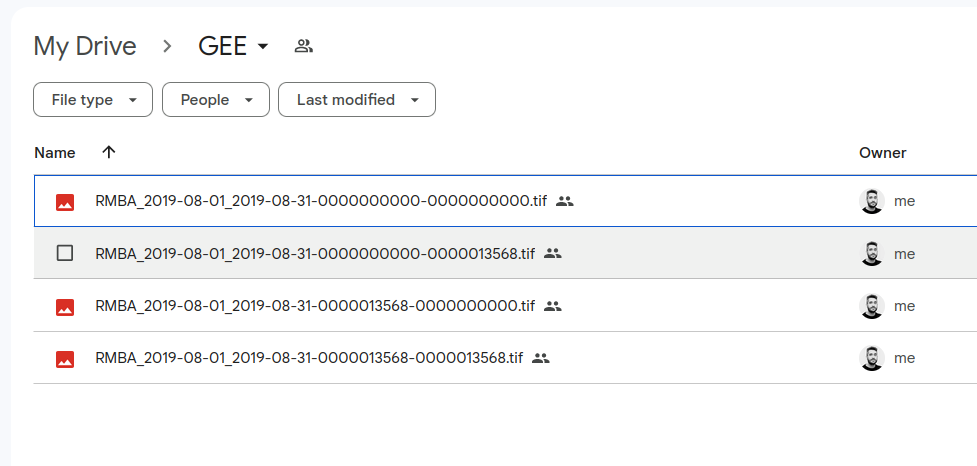